In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import *

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/03 20:46:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/03 20:46:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
data_loc = "../data/tables/"

consumer_fraud = spark.read.option("header", "true").csv(data_loc+"consumer_fraud_probability.csv")
merchant_fraud = spark.read.option("header", "true").csv(data_loc+"merchant_fraud_probability.csv")
raw_join = spark.read.parquet("../data/curated/raw_join_internal_table/")

<h2>1. Unsupervised Learning: to classify each instance into low, medium and high level of fraud probability</h2>

<h3>1.1 Determine whether an instance is an outlier based on dollor value (assumption: an outlier may be a fraud instance)</h3>

<h4>1.1.1 Extract and aggregate the dollar value for each user </h4>

In [3]:
# find the average dollor value for each user on each date
raw_join_date = (raw_join.groupBy("user_id", "order_datetime")
                        .agg(avg("dollar_value").alias("dollar_value_average"))
                        .orderBy("user_id"))

In [4]:
# find the average and standard deviation of dollor value for each user
join_std = (raw_join_date.groupBy("user_id")\
                         .agg(stddev_pop("dollar_value_average").alias("dollar_std"),
                              avg("dollar_value_average").alias("dollar_mean")))

<h4>1.1.2 Determine whether an instance is an outlier for corresponding user (0 is not outlier; 1 is outlier) </h4>

In [5]:
raw_join_outlier = (raw_join_date.join(join_std, "user_id", "left")
                   .withColumn("isOutlier",
                                F.when((abs(col("dollar_value_average") - col("dollar_mean")) <= 3 * col("dollar_std")), 0).otherwise(1))
                   .drop("dollar_mean")
                   .drop("dollar_std")
                   .drop("dollar_value_average"))

In [6]:
raw_join_outlier

22/10/03 20:46:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:46:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:46:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:46:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:46:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:46:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:46:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:46:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:47:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


user_id,order_datetime,isOutlier
1,2021-03-21,0
1,2021-05-12,0
1,2021-05-16,0
1,2021-07-30,0
1,2022-08-21,0
1,2021-05-03,0
1,2022-04-02,0
1,2021-10-31,0
1,2022-05-21,0
1,2021-11-13,0


<h3>1.2. Join with consumer fraud probability</h3>

In [7]:
consumer_fraud = consumer_fraud.withColumnRenamed("user_id", "user_id_alt")
consumer_fraud = consumer_fraud.withColumnRenamed("order_datetime", "order_datetime_alt")

In [8]:
raw_join_outlier.createOrReplaceTempView("consumer")
consumer_fraud.createOrReplaceTempView("probability")

consumer_prob = spark.sql("""
SELECT 
    user_id, order_datetime, fraud_probability, isOutlier
FROM 
    consumer
LEFT JOIN 
    probability
ON 
    consumer.user_id == probability.user_id_alt
AND 
    consumer.order_datetime == probability.order_datetime_alt
""")


In [9]:
# fill the non exists probability with 0.1
consumer_prob = consumer_prob.withColumn("fraud_probability", 
                            F.when((col("fraud_probability").isNull()), 0.1).otherwise(F.col("fraud_probability")))

In [10]:
# convert data type of features to ensure they can be vectorize
consumer_prob = consumer_prob.withColumn("fraud_probability", F.col("fraud_probability").cast("float"))

<h3>1.3. Vectorize and standardize the features to ensure they are suitible for the clustering model (k-means)</h3>

In [11]:
# vectorized the features for model training
from pyspark.ml.feature import VectorAssembler

features = 'features'
input_cols = ["fraud_probability", "isOutlier"]

assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols, 
    # How should the combined columns be named
    outputCol=features
)

consumer_transformed = assembler.transform(consumer_prob.dropna('any'))

In [12]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(consumer_transformed)

consumer_transformed = scalerModel.transform(consumer_transformed)

22/10/03 20:47:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [13]:
from pyspark.ml.feature import VectorIndexer

featureIndexer = VectorIndexer(inputCol="scaledFeatures", \
                               outputCol="indexedFeatures",\
                               maxCategories=3165
).fit(consumer_transformed)

consumer_transformed = featureIndexer.transform(consumer_transformed)

22/10/03 20:47:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:47:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<h3>1.4. Modelling using k-means and clustering </h3>

In [14]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol='indexedFeatures', k=3)
model = kmeans.fit(consumer_transformed.select("indexedFeatures"))
consumer_kmean = model.transform(consumer_transformed)
consumer_kmean = consumer_kmean.withColumnRenamed("prediction", "fraud_group")

22/10/03 20:48:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:48:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:48:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:48:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [15]:
consumer_kmean

22/10/03 20:49:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:49:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


user_id,order_datetime,fraud_probability,isOutlier,features,scaledFeatures,indexedFeatures,fraud_group
19979,2022-10-09,0.1,0,[0.10000000149011...,[0.09229378721488...,[0.09229378721488...,0
29,2021-04-28,0.1,0,[0.10000000149011...,[0.09229378721488...,[0.09229378721488...,0
474,2021-05-04,0.1,0,[0.10000000149011...,[0.09229378721488...,[0.09229378721488...,0
1677,2021-03-11,0.1,0,[0.10000000149011...,[0.09229378721488...,[0.09229378721488...,0
1697,2022-01-10,0.1,0,[0.10000000149011...,[0.09229378721488...,[0.09229378721488...,0
1806,2021-11-11,0.1,0,[0.10000000149011...,[0.09229378721488...,[0.09229378721488...,0
1950,2021-07-01,0.1,0,[0.10000000149011...,[0.09229378721488...,[0.09229378721488...,0
2040,2021-06-10,0.1,0,[0.10000000149011...,[0.09229378721488...,[0.09229378721488...,0
2509,2022-07-10,0.1,0,[0.10000000149011...,[0.09229378721488...,[0.09229378721488...,0
2509,2022-08-27,0.1,0,[0.10000000149011...,[0.09229378721488...,[0.09229378721488...,0


<h3>1.5. Check the clustering is followed by the assumption </h3>

In [16]:
consumer_check = consumer_kmean.groupBy("fraud_group").agg(mean("fraud_probability").alias("mean_prob"), 
                                          sum("isOutlier").alias("outlier_amount"), 
                                          count("isOutlier").alias("total_instance"))
consumer_check                                         

22/10/03 20:49:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:49:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:49:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


fraud_group,mean_prob,outlier_amount,total_instance
1,43.71548542520274,1795,2300
2,12.78110882133088,19832,30467
0,0.10000000149011612,123731,8724160


In [17]:
consumer_check = (consumer_check.withColumn("outlier_rate", F.col("outlier_amount")/F.col("total_instance"))
                               .drop(col("outlier_amount"))
                               .drop(col("total_instance")))

In [18]:
consumer_check

22/10/03 20:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:50:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:50:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:50:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:50:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:50:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:50:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


fraud_group,mean_prob,outlier_rate
1,43.71548542520274,0.7804347826086957
2,12.78110882133088,0.6509337972232251
0,0.10000000149011612,0.014182568866228954


Summary:
1. According to mean_prob, we can know that 0 represents low fraud probability, 2 represents medum one and 1 represents high one for fraud_group.
2. The level of fraud probability increases as the outlier_rate increases as well.

<h3>1.6. Add the fraud_group feature to the internal joined dataset</h3>

In [19]:
add_fraud = raw_join.join(consumer_kmean, ["user_id", "order_datetime"], "left")

In [20]:
add_fraud = add_fraud.drop("fraud_probability", "isOutlier", "features", "scaledFeatures", "indexedFeatures")

In [21]:
# import time
# import datetime
# date = "2021-02-01"
# date_time = datetime.datetime.strptime(date, '%Y-%m-%d')

# user = 20984

In [22]:
# raw_join.where((col("order_datetime") == date_time.date()) & (col("user_id") == user))

In [23]:
# merchant_consumer_info.where((col("order_datetime") == date_time.date()) & (col("user_id") == user))

<h2>2. Outlier removal</h2>

<h3>2.1 Get distribution for each revenue level</h3>

22/10/03 20:50:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

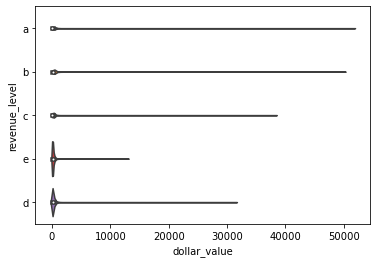

In [24]:
import seaborn as sns
sns.violinplot(data=add_fraud.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level")

22/10/03 20:51:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:51:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

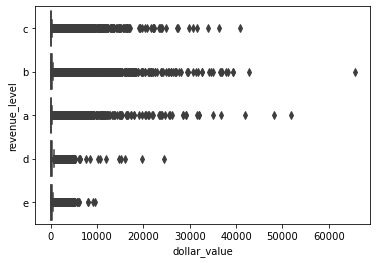

In [25]:
sns.boxplot(data=add_fraud.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level")

<h4>2.1.1 Remove outliers based on standard deviation</h4>

In [26]:
rev_std = (add_fraud.groupBy("revenue_level").agg(stddev_pop("dollar_value").alias("dollar_value_std"),
                                             avg("dollar_value").alias("dollar_value_mean")))
rev_std

22/10/03 20:52:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:52:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:52:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:52:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:52:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:52:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


revenue_level,dollar_value_std,dollar_value_mean
e,399.0600030109279,205.81060473911967
d,681.0178374382818,272.2615583756089
c,439.15886606318327,136.61671509843887
b,607.8880371974792,197.49554046383884
a,366.05908217395506,142.1910239390063


In [27]:
total = add_fraud.count()
rev_sdf = (add_fraud.join(rev_std, "revenue_level", "left")
               .filter(abs(col("dollar_value") - col("dollar_value_mean")) <= 3 * col("dollar_value_std"))
               .drop("dollar_value_mean")
               .drop("dollar_value_std"))
print(f"Outliers based on revenue band removed: {total - rev_sdf.count()}")

22/10/03 20:53:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:53:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:53:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:53:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Outliers based on revenue band removed: 133177


<h4>2.1.2 Check distribution</h4>

22/10/03 20:54:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:54:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

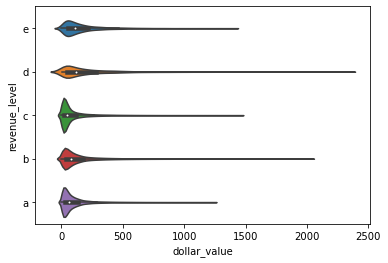

In [28]:
sns.violinplot(data=rev_sdf.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level")

22/10/03 20:55:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:55:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:55:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:55:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

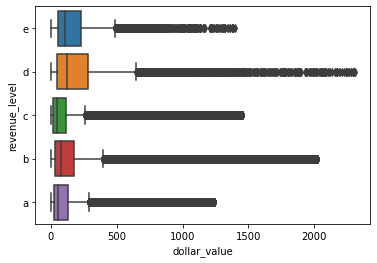

In [29]:
sns.boxplot(data=rev_sdf.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level")

<h3>2.2 Get distribution of each merchant</h3>

In [30]:
merch_std = (rev_sdf.groupBy("merchant_name").agg(stddev_pop("dollar_value").alias("dollar_value_std"),
                                                  avg("dollar_value").alias("dollar_value_mean")))
merch_std

22/10/03 20:56:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:56:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:56:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:56:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


merchant_name,dollar_value_std,dollar_value_mean
Donec Luctus Indu...,130.55650157165087,343.7164090501804
Dictum Mi Incorpo...,368.6617885233332,471.0796502665339
Amet Nulla Ltd,54.829244108560125,86.38047478621885
Vel Turpis Company,206.33110261321298,464.72620295222833
Montes Limited,439.10765611177374,605.2590616193932
Semper Incorporated,60.331578814546525,103.80269405622981
Mollis Integer Co...,35.72032434616897,35.398257757498065
Porttitor Eros In...,64.63472631463996,99.9656757050358
Malesuada Vel Ltd,201.89377133366614,242.10833374759574
Arcu Vestibulum C...,193.42764677473969,301.1974486572265


In [31]:
total = rev_sdf.count()
merch_sdf = (rev_sdf.join(merch_std, "merchant_name", "left")
                   .filter(abs(col("dollar_value") - col("dollar_value_mean")) <= 3 * col("dollar_value_std"))
                   .drop("dollar_value_mean")
                   .drop("dollar_value_std"))
print(f"Outliers based on merchant removed: {total - merch_sdf.count()}")

22/10/03 20:57:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:57:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 20:57:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:57:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Outliers based on merchant removed: 175313


In [32]:
merch_sdf.write.parquet("../data/curated/merchant_consumer_info")

22/10/03 20:58:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 20:58:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
